In [1]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.16.2


In [2]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from tensorflow.keras.utils import Sequence

In [3]:
# Paths
DATASET_PATH = "/Users/faizal/work/gnprc-domi-app/datasets/archive/sample_synth_datasets/ds5.0"  # Replace with the dataset directory
ANNOTATION_FILE = os.path.join(DATASET_PATH, "data")  # Keypoint annotations
IMAGES_FOLDER = os.path.join(DATASET_PATH, "data")  # Images folder

# Constants
OUTPUT_SIZE = (224, 224)  # Resize images to 224x224
AUGMENTATION = True      # Toggle data augmentation

In [4]:
def visualize_image(image, keypoints=None, bbox=None):
    """Utility function to visualize images with keypoints and bounding boxes."""
    plt.imshow(image[..., ::-1])  # Convert BGR to RGB
    if bbox:
        x, y, w, h = bbox
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2))
    if keypoints is not None and keypoints.size > 0:
        if len(keypoints) % 3 != 0:
            raise ValueError("Keypoints array length must be a multiple of 3.")
        for i in range(0, len(keypoints), 3):
            x, y, v = keypoints[i:i + 3]
            if v > 0:  # Visibility flag > 0 means keypoint is visible
                plt.plot(x, y, 'go', markersize=5)
    plt.axis('off')
    plt.show()


In [5]:
def augment_data(image, bbox, keypoints):
    """Apply data augmentation (flip, rotate, etc.) to an image and annotations."""
    height, width = image.shape[:2]

    # Example: Horizontal flip
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)
        bbox[0] = 1 - bbox[0] - bbox[2]  # Adjust x-coordinate of the bounding box
        for i in range(0, len(keypoints), 3):
            if keypoints[i] > 0:
                keypoints[i] = 1 - keypoints[i]  # Flip x-coordinate of keypoints

    # Additional augmentations like rotation, scaling, or noise can be added here.
    return image, bbox, keypoints

In [6]:
def preprocess_dataset(images_folder, annotations_folder, output_size):
    """
    Preprocess rgba.json and rgba.png files to extract relevant training data.
    
    Args:
        images_folder (str): Path to the folder containing rgba.png files.
        annotations_folder (str): Path to the folder containing rgba.json files.
        output_size (tuple): Target size for resizing images (width, height).
    
    Returns:
        images (list): Preprocessed images.
        bboxes (list): Bounding boxes (normalized).
        keypoints (list): Keypoints (normalized).
        values (list): Corresponding gauge readings.
    """
    images, bboxes, keypoints, values = [], [], [], []
    
    # Iterate through all image files
    for filename in os.listdir(images_folder):
        if filename.endswith(".png"):
            # Match image with corresponding annotation file
            image_path = os.path.join(images_folder, filename)
            json_path = os.path.join(annotations_folder, filename.replace(".png", ".json"))
            
            if not os.path.exists(json_path):
                print(f"Annotation file not found for {filename}")
                continue
            
            # Load image
            image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # RGBA image
            if image is None:
                print(f"Failed to load image {filename}")
                continue
            
            # Load annotation
            with open(json_path, 'r') as f:
                annotation_data = json.load(f)
            
            # Resize image
            height, width = image.shape[:2]
            resized_image = cv2.resize(image, output_size)
            
            # Extract data from annotation
            for annotation in annotation_data:
                bbox = annotation['bbox']  # x, y, width, height
                category_name = annotation['category_name']
                keypoints = annotation.get('keypoints', [])
                synth_dial_value = annotation.get('synth_dial_value', None)
                
                # Normalize bounding box and keypoints
                normalized_bbox = [
                    bbox[0] / width, bbox[1] / height,
                    bbox[2] / width, bbox[3] / height
                ]
                normalized_keypoints = [
                    kp / width if i % 3 == 0 else kp / height if i % 3 == 1 else kp
                    for i, kp in enumerate(keypoints)
                ]
                
                # Append data
                images.append(resized_image)
                bboxes.append(normalized_bbox)
                keypoints.append(normalized_keypoints)
                values.append(synth_dial_value)
    
    return np.array(images), np.array(bboxes), np.array(keypoints), np.array(values)

In [7]:
def save_preprocessed_data(X, y_keypoints, y_bboxes, output_dir="preprocessed_data"):
    """Save preprocessed data for reuse."""
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "X.npy"), X)
    np.save(os.path.join(output_dir, "y_keypoints.npy"), y_keypoints)
    np.save(os.path.join(output_dir, "y_bboxes.npy"), y_bboxes)
    print(f"Preprocessed data saved to {output_dir}")

Preprocessed data saved to preprocessed_data


/var/folders/rt/0x35vmdd32ldd69_8j6wrvgc0000gn/T/ipykernel_25121/1191351467.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if bbox:


ValueError: Keypoints array length must be a multiple of 3.

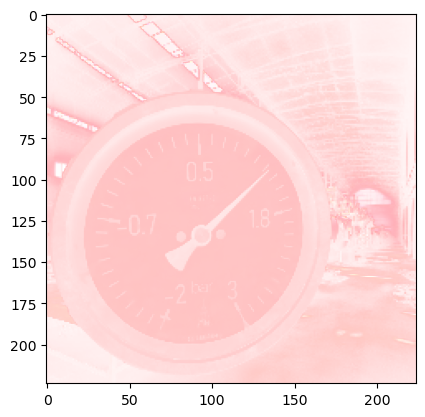

In [8]:
# Preprocess dataset
X, y_keypoints, y_bboxes, y_values = preprocess_dataset(
    IMAGES_FOLDER, ANNOTATION_FILE, OUTPUT_SIZE
)

# Save data for training
save_preprocessed_data(X, y_keypoints, y_bboxes)

# Visualize sample data
visualize_image(X[0], y_keypoints[0], y_bboxes[0])